# Практическая работа к уроку №3

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch import nn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [21]:
!nvidia-smi

Fri Mar 25 19:00:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    59W / 149W |    534MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Подготовка данных

In [4]:
!unzip -q /content/gdrive/MyDrive/GeekBrains/PyTorch/03_lesson/train.csv.zip

In [22]:
data = pd.read_csv("/content/train.csv")
data.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [23]:
def prepare_data(df):
    # отбор признаков
    df = df[['parent_category_name', 'category_name', 'price',
             'item_seq_number', 'user_type', 'deal_probability']]

    # Label encoding
    for column in ['parent_category_name', 'category_name', 'user_type']:
        le = preprocessing.LabelEncoder()
        df[column] = le.fit_transform(df[column])

    # подсчитаем средний ценник в каждой категории и заполним NaN цены
    median_price_per_category = dict(df.groupby('category_name')['price'].median())
    df['price'] = df[['category_name', 'price']].apply(lambda row: median_price_per_category[row[0]] if np.isnan(row[1]) else row[1], axis=1)

    # train test split
    train_df, test_df = train_test_split(df, test_size=0.25, random_state=13)
    print(f"{df.shape} -> train: {train_df.shape} and test: {test_df.shape}")

    return train_df, test_df

In [24]:
train_df, test_df = prepare_data(data)
train_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(1503424, 6) -> train: (1127568, 6) and test: (375856, 6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,parent_category_name,category_name,price,item_seq_number,user_type,deal_probability
31723,6,9,329000.0,6,1,0.00000
929954,4,29,900.0,16,1,0.00000
1143227,6,0,140000.0,1,1,0.73760
484798,0,41,10000.0,1,1,0.33973
898764,6,0,53000.0,1,1,0.47553


In [25]:
class AvitoDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self._df = np.array(df.values)

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        inputs = torch.from_numpy(self._df[idx][:-1]).float()
        target = torch.from_numpy(self._df[idx][-1:]).float()
        return inputs, target

In [26]:
train_dataset = AvitoDataset(train_df)
test_dataset = AvitoDataset(test_df)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=128,
                                shuffle=True)
test_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=128,
                                shuffle=False)

## Архитектура модели

In [27]:
class SimpleModel(nn.Module):
    def __init__(self, input_dim, dim):
        super(SimpleModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, 2 * dim)
        self.bn3 = nn.BatchNorm1d(2 * dim)
        self.fc3 = nn.Linear(2 * dim, dim)
        self.dp = nn.Dropout(0.2)
        self.fc4 = nn.Linear(dim, 1)
    
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.1)
        x = self.bn2(x)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.1)
        x = self.bn3(x)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.1)
        x = self.dp(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return x


## Обучение

In [28]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(True):
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data

    return train_loss

def test_epoch(model, train_loader, criterion):
    model.eval()

    running_loss = 0.0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data

    return train_loss

def train(model, train_loader, test_loader, criterion, optimizer, epochs):
    history = {
        'train_loss': [],
        'test_loss': [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        test_loss = test_epoch(model, test_loader, criterion)

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)

        print(f"train_loss: {train_loss}; test_loss: {test_loss};")
    
    return history

RMSE loss из kaggle

In [29]:
def rmse_loss(y_pred, y_real):
    return torch.sqrt(torch.mean(torch.pow(y_pred - y_real, 2)))

In [30]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
def get_optimizer(model, opt_name):
    if opt_name == 'Adam':
        return torch.optim.Adam(model.parameters(), lr=0.01)
    elif opt_name == 'RMSprop':
        return torch.optim.RMSprop(model.parameters(), lr=0.01)
    elif opt_name == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=0.01)
    raise ValueError

In [33]:
optimizers = ['Adam', 'RMSprop', 'SGD']
epochs = 10
history = {}
dir_path = "/content/gdrive/MyDrive/GeekBrains/PyTorch/03_lesson"

for opt_name in optimizers:
    model = SimpleModel(train_df.shape[1] - 1, 32)
    model = model.to(DEVICE)

    optimizer = get_optimizer(model, opt_name)

    logs = train(model, train_loader, test_loader, rmse_loss, optimizer, epochs)

    history[opt_name] = logs

    torch.save(model.state_dict(), f"{dir_path}/model_{opt_name}.pth")

 10%|█         | 1/10 [01:17<11:40, 77.85s/it]

train_loss: 0.24315664320987515; test_loss: 0.24210577935342809;


 20%|██        | 2/10 [02:36<10:28, 78.50s/it]

train_loss: 0.24047036142828834; test_loss: 0.24386949555837975;


 30%|███       | 3/10 [03:53<09:02, 77.48s/it]

train_loss: 0.24004600720011918; test_loss: 0.2428149422490189;


 40%|████      | 4/10 [05:07<07:37, 76.18s/it]

train_loss: 0.23974757290227494; test_loss: 0.24654597767682634;


 50%|█████     | 5/10 [06:21<06:17, 75.46s/it]

train_loss: 0.2396228576035321; test_loss: 0.24511375492777118;


 60%|██████    | 6/10 [07:36<05:01, 75.29s/it]

train_loss: 0.239498710568637; test_loss: 0.24348743540874843;


 70%|███████   | 7/10 [08:48<03:42, 74.25s/it]

train_loss: 0.2394778409731819; test_loss: 0.24619925771105608;


 80%|████████  | 8/10 [10:07<02:31, 75.74s/it]

train_loss: 0.23937808998732482; test_loss: 0.24731804917971145;


 90%|█████████ | 9/10 [11:21<01:15, 75.24s/it]

train_loss: 0.2393187153864277; test_loss: 0.24763651362591763;


100%|██████████| 10/10 [12:34<00:00, 75.41s/it]


train_loss: 0.23929153801502637; test_loss: 0.2459905882459077;


 10%|█         | 1/10 [01:05<09:46, 65.21s/it]

train_loss: 0.24268361466059124; test_loss: 0.24085308417857396;


 20%|██        | 2/10 [02:12<08:50, 66.29s/it]

train_loss: 0.24046186598984723; test_loss: 0.24490131720247804;


 30%|███       | 3/10 [03:18<07:43, 66.25s/it]

train_loss: 0.24006368495618974; test_loss: 0.24675727343605952;


 40%|████      | 4/10 [04:24<06:37, 66.21s/it]

train_loss: 0.23987017280047485; test_loss: 0.24499671233171785;


 50%|█████     | 5/10 [05:30<05:30, 66.02s/it]

train_loss: 0.23971095208018942; test_loss: 0.24392893145188682;


 60%|██████    | 6/10 [06:35<04:23, 65.85s/it]

train_loss: 0.23960019781518022; test_loss: 0.24323744703149092;


 70%|███████   | 7/10 [07:41<03:17, 65.86s/it]

train_loss: 0.2395069371326002; test_loss: 0.2472420646287103;


 80%|████████  | 8/10 [08:46<02:11, 65.62s/it]

train_loss: 0.2394497143035292; test_loss: 0.24543886990010144;


 90%|█████████ | 9/10 [09:51<01:05, 65.33s/it]

train_loss: 0.23939094352496854; test_loss: 0.2447136606641391;


100%|██████████| 10/10 [10:56<00:00, 65.60s/it]


train_loss: 0.2393586250328411; test_loss: 0.24574628597968787;


 10%|█         | 1/10 [00:58<08:46, 58.52s/it]

train_loss: 0.2889718365625608; test_loss: 0.2502395718684624;


 20%|██        | 2/10 [01:56<07:43, 57.98s/it]

train_loss: 0.2517333625233185; test_loss: 0.2474886832529816;


 30%|███       | 3/10 [02:53<06:43, 57.63s/it]

train_loss: 0.24973036047468364; test_loss: 0.24633112745220384;


 40%|████      | 4/10 [03:51<05:46, 57.74s/it]

train_loss: 0.24849866781424299; test_loss: 0.24553106751857978;


 50%|█████     | 5/10 [04:48<04:47, 57.57s/it]

train_loss: 0.24777093415690107; test_loss: 0.2450812894680703;


 60%|██████    | 6/10 [05:47<03:51, 57.94s/it]

train_loss: 0.2471664231900922; test_loss: 0.2444461834507576;


 70%|███████   | 7/10 [06:45<02:54, 58.19s/it]

train_loss: 0.2466485317118629; test_loss: 0.24402624638344514;


 80%|████████  | 8/10 [07:43<01:56, 58.01s/it]

train_loss: 0.24634427348463128; test_loss: 0.2438051675303223;


 90%|█████████ | 9/10 [08:39<00:57, 57.52s/it]

train_loss: 0.24585517445261237; test_loss: 0.24388627742296884;


100%|██████████| 10/10 [09:36<00:00, 57.62s/it]

train_loss: 0.24541984520935134; test_loss: 0.24394476370021131;


## Результаты

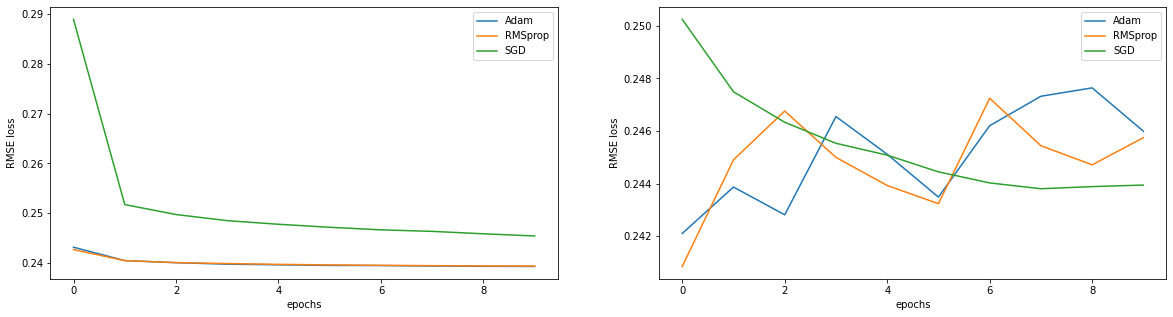

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

for opt_name, items in history.items():
    ax1.plot(items['train_loss'], label=opt_name)
ax1.set_xlabel('epochs')
ax1.set_ylabel('RMSE loss')

for opt_name, items in history.items():
    ax2.plot(items['test_loss'], label=opt_name)
ax2.set_xlabel('epochs')
ax2.set_ylabel('RMSE loss')

ax1.legend()
ax2.legend()
plt.show()

In [78]:
def rmse_metric(model):
    targets = []
    preds = []
    model.eval()
    with torch.set_grad_enabled(False):
        for x, y in tqdm(test_loader):
            y_pred = model(x.to(DEVICE)).cpu()
            targets.append(y)
            preds.append(y_pred)
    targets = torch.cat(targets)
    preds = torch.cat(preds)
    return float(rmse_loss(preds, targets))

In [79]:
results = {}

for opt_name in optimizers:
    print(opt_name)
    model = SimpleModel(train_df.shape[1] - 1, 32)
    model = model.to(DEVICE)
    model.load_state_dict(torch.load(f"{dir_path}/model_{opt_name}.pth"))
    results[opt_name] = rmse_metric(model)

Adam


100%|██████████| 8810/8810 [00:22<00:00, 384.63it/s]


RMSprop


100%|██████████| 8810/8810 [00:21<00:00, 405.64it/s]


SGD


100%|██████████| 8810/8810 [00:22<00:00, 397.03it/s]


In [89]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])\
                .sort_values(by='RMSE', ascending=True)
df_results

,RMSE
SGD,0.244980
RMSprop,0.247027
Adam,0.247317


Модели на всех оптимизаторах дообучились, так как по графикам лосса на трейне видно, что вышли на плато.

Adam и RMSprop показали одинаковые темпы обучения как на трейновой выборке, так и на тестовой. Модель на данных 2 оптимизаторах постепенно переобучается и очень неустойчива на тестовой выборке.

Модель, обученная с оптимизатором SGD, хоть и показала более плохие результаты в процессе обучения, но приобрела большую обобщающую способность на тестовой выборке. Лосс на тесте также выравнился и модель на удивление стабильна, хотя по логике стохастический градиентный спуск должен быть менее стабильным.

Таким образом, модель, обученная с оптимизатором SGD, оказалась самой лучшей.
